# Problem Description

In [8]:
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from IPython.display import display
from rmgpy.cantherm.output import prettify

In [2]:
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries='none',\
             kineticsFamilies='none', kineticsDepositories='none', reactionLibraries = [])

thermoDatabase = database.thermo

## Example 1

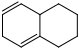

ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([201.585, 254.178, 299.407, 336.31, 393.003, 433.923, 493.586], 'J/(mol*K)'),
    H298 = (46.7353, 'kJ/mol'),
    S298 = (194.305, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (582.013, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing)',
)


In [14]:
spec1 = Species().fromSMILES('C1C=CC2CCCCC2=C1')
spec1.generateResonanceIsomers()
display(spec1)
print prettify(repr(thermoDatabase.getThermoDataFromGroups(spec1)))

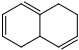

ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([158.448, 212.129, 258.069, 295.6, 351.582, 391.037, 449.654], 'J/(mol*K)'),
    H298 = (175.657, 'kJ/mol'),
    S298 = (397.815, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (532.126, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt19-1)',
)


In [15]:
spec1_sib = Species().fromSMILES('C1C=CC2CC=CC=C2C1')
spec1_sib.generateResonanceIsomers()
display(spec1_sib)
print prettify(repr(thermoDatabase.getThermoDataFromGroups(spec1_sib)))

`spec1` only matches the most generic polycyclic correction, while its sibling `spec1_sib` in below can find a specific correction. So here is 

**PROBLEM 1: The correction data in database is not effectively used; it's only used if a exact match is found.**

**SOLUTION: re-organize the polycyclic tree to enable RMG to use sibling info.**

# Example 2

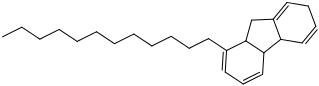

ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([483.21, 625.675, 749.815, 850.984, 1005.96, 1116.84, 1280.56], 'J/(mol*K)'),
    H298 = (-8.24248, 'kJ/mol'),
    S298 = (754.613, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (1504.92, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH)

In [17]:
spec2 = Species().fromSMILES('CCCCCCCCCCCCC1=CC=CC2C3C=CCC=C3CC12')
spec2.generateResonanceIsomers()
display(spec2)
print prettify(repr(thermoDatabase.getThermoDataFromGroups(spec2)))

`spec2` has a 3-ring polycyclic group, but it partially matches a 2-ring polycyclic correction. We know it probably has very different correction from the actual 3-ring correction. So here is 

**PROBLEM 2: we don't have enough data in database**

**SOLUTION: detect partial match for polycyclic molecules, spawn QM job and enlarge the database. In the meantime, for large molecules, we might also want to develop a heuristic/machine learning way of estimating polycyclic correction.**

# Example 3

Currently when having new data for polycyclic groups, we simply insert it in L2 as below
```python
...
    L2: INDENE
    L2: INDENE-1
    L2: 2HINDENE
    L2: prod2
    L2: prod2-1
    L2: prod4
    L2: prod4-1
    L2: naphthalene
    L2: naphthalene-1
```
**PROBLEM 3** includes two issues:

- worsen the problem shown in `Example 1`, if no exact match, return to generic node directly.

- hard to figure out what data we are lacking, what we add is just some examples not systematic solution.

# Potential Contributions to Make

- Re-organize the polycyclic tree in a checmically sensible way which helps
    
    - better use available sibling data when no exact match is found
    
    - figure out what data is lacking
    
    - gain insights for generalization
    
- Provide a scheme to use tree as a building block to best guess for complicated polycyclic ring correction

- Automatic workflow to enlarge polycyclic database from identification through QM job to new entry insertion. 